In [ ]:
# To get the image and caption data from Google Drive.
from google.colab import drive

# To prevent seeing the error messages
import warnings
warnings.filterwarnings('ignore')

# For preprocessing captions and storing them in 
# memory as dictionary
from collections import defaultdict

# To navigate across folders and accessing data
import os

# For preprocessing captions
import string
import random
import re

# For matrix and math operations
import numpy as np
import math

# For formatting output while viewing training logs
import sys
import pandas as pd

# To compute the time required for training a 
# batch, an epoch etc. and to track the progress of a loop
import time
from tqdm import tqdm_notebook as tqdm

# For storing models and image features
from pickle import dump, load
from PIL import Image

# For Building the neural network architecture for caption generation
from keras.applications.resnet import ResNet50                                  # For encoding images as vectors using pretrained ImageNet weights for ResNet architecture
from keras.preprocessing.image import load_img                                  # To load an image in memory
from keras.preprocessing.image import img_to_array                              # To convert an image into a numpy array
from keras.applications.resnet50 import preprocess_input                        # To preprocess input (normalization, rescaling etc.) before passing into ResNet50 architecture
from keras.models import Model                                                  # To build a model for Compressing images to feature vectors
%tensorflow_version 1.x

from keras.preprocessing.text import Tokenizer                                  # To convert text sequences to tokens
from keras.preprocessing.sequence import pad_sequences                          # To pad captions to generate equal sized tensors for input to sequence model
from keras.utils import to_categorical                                          # To convert individual words to one-hot encoded vectors for getting ideal prob distribution

from keras.layers import Input, Dense, Embedding, Dropout, LSTM, add            # Layers needed to define the caption generator architecture
from keras.models import Model                                                  # To define architecture using layers above for generating captions
from keras.utils import plot_model                                              # To create a schematic for the defined model
from keras import optimizers                                                    # To define the algorithm to be used for learning (SGD, Adam etc.)
from keras.models import load_model                                             # To load a saved model for continuing the training from an intermediate checkpoint

# To validate the output captions against any one input
# Set of captions
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# To plot images in notebook and format figure dimensions
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

# To mount drive and set the working directory
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive')

Using TensorFlow backend.


Mounted at /content/drive


In [ ]:
# Import the encoder and decoder classes from model.py file
from helper_functions import clean_caption, read_txt

In [ ]:
# Make sure that the available GPU is used
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [ ]:
# To view the NVIDIA GPU that our instance is connected to
!nvidia-smi

Sun Feb 23 07:29:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    22W /  75W |    115MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Caption Preprocessing

In [ ]:
tokens = '/content/drive/My Drive/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt'

In [ ]:
# Read all the captions into a list "captions"
captions = []
with open(tokens, 'r') as op:
  captions = op.readlines()

## Cleaning the captions

There are some operations we need to perform before we store the captions.

- Convert all caption words to lowercase. We do not care for casing here. A lowercase `a` and an uppercase `A` are the same semantically for the sake of this task.

- Punctuations don't mean anything. The descriptions are supposed to be short and objective in nature. Punctuations do not add any value in that aspect since they're used to convey other lingual information like pauses or emotions or tone which is out of scope of this task.

- Objective words which convey meaning have at least two letters in their words. The only two one letter words are A and I which aren't important for the reason specified. So, remove them from our captions.

Eventually, save these captions in a text form in the format

> \<image_name\> \<caption\>

This will then become a one-time process which need not be repeated over and again.

In [ ]:
def clean_caption(caption):
  '''
  Given a caption, convert it to lowercase and remove all the punctuation marks
  from the same. Also checks if the word is a legit word i.e. only contains alphabets
  '''
  all_marks = r'[' + ''.join(['\\' + i for i in string.punctuation]) + ']'      # Get a list of all the punctuation marks so that they can be replaced
  caption = caption.lower()                                                     # Get the caption into lowercase
  caption = re.sub(all_marks, '', caption)                                      # Substitute punctutation marks with an empty string
  caption = ' '.join([i for i in caption.split(' ') if (i.isalpha() and len(i) > 1)]) # Get cleaned caption from a list into a string form
  return caption

In [ ]:
captions = [re.sub('\t', ' ', i) for i in captions]
captions = [re.sub('\n', ' ', i) for i in captions]
all_caps = []                                                                   # Container to hold captions in the form <img> <caption>
just_caps = []                                                                  # Container to hold all the captions for generating vocabulary

for item in captions:
  key = re.findall(r'(.+)#\d', item)[0]                                         # Before the hashtag, we have the name of image. Extract name of image
  caption = re.findall(r'.+#\d (.+)', item)[0]                                  # After hashtag and number, we have the entire caption. Extract that.
  caption = clean_caption(caption)                                              # Use the function described above to clean the caption
  just_caps.append(caption)                                                     # Store caption in just_caps
  all_caps.append(f"{key} {caption}")                                           # Store <img> <caption> in all_caps

# Write cleaned descriptions as a mapping between image and caption to a file
with open("cleaned_descriptions.txt", "w") as op:
  op.write("\n".join(all_caps))

# Create a vocabulary from the specified words
vocab = set(" ".join(just_caps).split(" "))

## Determine suitable caption length

We can see that many captions are medium sized whereas some captions are too small and some captions too large. 

For making our LSTMs learn appropriate sequences we should fix a length of sequences. This needs to be done in order to convert all captions into a homogeneous length so that they could be passed through the LSTM. 

**PS: Also we need to ensure that only words that appear more than a certain number of times make it through our vocabulary. This is essential for training the embedding vector for different words. If some words appear only once, then even after sufficient number of epochs they won't be learned well. And if we increase the number of epochs without any restraint (for better learning of word embeddings), then most likely our model will start overfitting. Therefore let's temporarily set the word threshold to 2.**

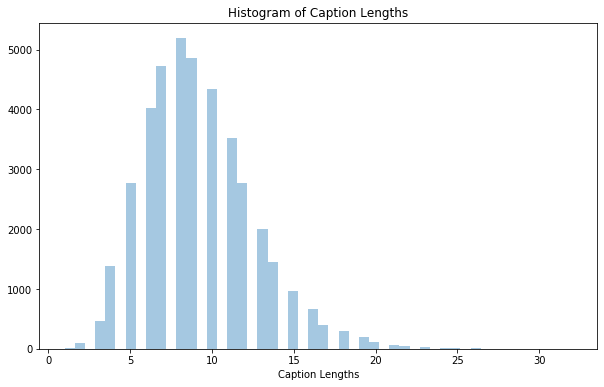

In [ ]:
rcParams['figure.figsize'] = 10, 6
cap_lengths = [len(i.split(' ')) for i in just_caps]

ax = sns.distplot(cap_lengths, kde = False)
ax.set_title("Histogram of Caption Lengths")
ax.set_xlabel("Caption Lengths");

In [ ]:
lengths, counts = np.unique(cap_lengths, return_counts = True)
counts = pd.DataFrame({"Caption Length": lengths, "# of Captions": counts})
counts

,Caption Length,# of Captions
0,1,7
1,2,103
2,3,471
3,4,1383
4,5,2773
5,6,4028
6,7,4734
7,8,5191
8,9,4862
9,10,4336


From the histogram and the table above, it seems a sequence length of 20 is decent. Cumulatively, there aren't even 1% of captions which are length 20 or more. Therefore we'll truncate the captions which exceed length 20 to be equal to length 20.

In [ ]:
  max_length = 20
  vocab_threshold = 2

## Loading Clean Captions

Now that we have cleaned up our captions, we need to segregate them into train, validation and test captions and store them systematically.

We are provided with three text files which hold the names to train, development and test images which we need to parse and then use that to load the captions.

- Train: **Flickr_8k.trainImages.txt**
- Validation/Development: **Flickr_8k.devImages.txt**
- Test: **Flickr_8k.testImages.txt**

These are present in the Flickr8k_text folder. We can load the image names and then use `defaultdict` to load the captions for these images in a dictionary of lists.

In [ ]:
def read_image_names(path):
  '''
  Given path to a text file with image names mentioned linewise,
  extracts them all in a list, removes endline character from them
  and returns the same.
  '''
  names = None
  
  with open(path, "r") as op:
    names = op.readlines()
  
  names = [re.sub('\n', '', i) for i in names]
  
  return names

In [ ]:
image_names_base_pth = '/content/drive/My Drive/flicker8k-dataset/Flickr8k_text'

train_image_names = read_image_names(image_names_base_pth + '/Flickr_8k.trainImages.txt')
valid_image_names = read_image_names(image_names_base_pth + '/Flickr_8k.devImages.txt')
test_image_names = read_image_names(image_names_base_pth + '/Flickr_8k.testImages.txt')

In [ ]:
def get_descriptions(desc_path, image_names):
  '''
  Given path to a description text file and names of images of which
  captions are to be scraped, does so and returns a dictionary with
  key as the name of image and value as the list of associated captions.
  '''
  descriptions = defaultdict(lambda: [])

  all_captions = []                                                             # Container for storing  all captions
  
  with open(desc_path, "r") as op:
    all_captions = op.readlines()                                               # Loading every caption in the container
  
  all_captions = [re.sub('\n', '', i) for i in all_captions]                    # Clean the caption of it's newline character

  for caption in all_captions:
    constituents = caption.split(' ')                                           # Break the caption into parts
    name = constituents[0]                                                      # Individual line is of type <img name> <caption>, so get the img name
    
    if name in image_names:
      cap = 'startseq ' + ' '.join(constituents[1:(max_length + 1)]) + ' endseq'      # Append the caption with a start and end token and only include first max_length words in caption
      descriptions[name].append(cap)                                            # Add the processed caption as a member of the img_name's list in the dictionary
  
  return descriptions

In [ ]:
clean_desc_path = '/content/drive/My Drive/cleaned_descriptions.txt'

train_descriptions = get_descriptions(clean_desc_path, train_image_names)
valid_descriptions = get_descriptions(clean_desc_path, valid_image_names)
test_descriptions = get_descriptions(clean_desc_path, test_image_names)

# Image Preprocessing

In order to train our caption generator, we have to represent images numerically as consistent sized arrays so that they could be fed into a Neural Network architecture and we could thereby generate captions from the same. It is possible to do so with the help of transfer learning.

As a part of the [ImageNet Classification Challenge](https://en.wikipedia.org/wiki/ImageNet) many people built many neural network architectures for the classification task. A notable thing that came out is that these networks being tuned to identifying diverse categories and having seen a lot of pictures, captured the underlying hierarchies and could therefore be used for a variety of tasks.

Therefore we will use an architecture called [Resnet50](https://cv-tricks.com/wp-content/uploads/2019/07/ResNet50_architecture-1.png) to convert our images to an n-dimensionl vector.
We will remove the eventual 1000 class classification layer and only keep information until the second last fully connected layer whose output is of shape (2048, 1). 

In [ ]:
def extract_features(source, destination = 'Resnet50_Image_Features.pkl'):
  '''
  Given a path, extract the ResNet50 Encoded Vectors for representing that
  image. The source path structure should be of the form source/directory/image_names
  '''       
  model = ResNet50()                                                            # Define the model that you want to use.  
  model.layers.pop()                                                            # Remove the final 1000 class classification output layer of imagenet  
  Compressor = Model(inputs = model.inputs, outputs = model.layers[-1].output)  # Create a Neural network architecture with the available model weights

  # Create a defaultdict to hold the vector representation of our images
  vector_size = int(Compressor.layers[-1].output.shape[1])
  image_features = defaultdict(lambda: np.zeros(1, vector_size)) 

  for folder in os.listdir(base_path):
    image_directory = f"{base_path}/{folder}"
    
    print(f"\nExtracting features from {folder} directory")

    total_images = len(os.listdir(image_directory))
    total_time = 0
    avg_time_per_img = 0
    measures = None

    for j, image_name in enumerate(os.listdir(image_directory)):
      start = time.time()
      
      image_filepath = f"{image_directory}/{image_name}"                        # Complete filepath generation
      image = load_img(image_filepath, target_size=(224,224))                   # Load the image in memory      
      image = img_to_array(image)                                               # Convert the image to a numpy array     
      rows, columns, channels = image.shape                                     # Get image dimensions      
      image = image.reshape((1, rows, columns, channels))                       # Reshape the image such that batch is the first dimension (in this case, 1)      
      image = preprocess_input(image)                                           # Get the image ready in order to put it through the Compressor we defined above      
      features = Compressor.predict(image)                                      # Extract the features from the ConvNet      
      image_features[image_name] = features                                     # Save the features to a dictionary

      # Compute time needed for loading images
      current_encoding_time = time.time() - start
      total_time += current_encoding_time
      avg_time_per_img = np.round(total_time / (j + 1), 3)
      est_time = np.round(avg_time_per_img * (total_images - (j + 1)), 3)

      measures = f"Encoded {j+1}/{total_images} images, Average time of encoding: {avg_time_per_img}s, Current image encode time: {np.round(current_encoding_time, 3)}s, Estimated time of completion: {est_time}s"
      print(f'\r{measures}', end = "")
      sys.stdout.flush()
    
    print()   
    
  dump(dict(image_features), open(destination, 'wb'))

In [ ]:
base_path = '/content/drive/My Drive/flicker8k-dataset/Flickr8k_Dataset' 
extract_features(base_path)

In [ ]:
def get_image_features(features_path, image_names):
  '''
  Given a path which hosts the features obtained from passing an image through the
  resnet architecture and the image name, obtain the corresponding features from the 
  saved features dictionary
  '''
  all_features = load(open(features_path, 'rb'))
  features = {k: all_features[k] for k in image_names}
  return features

In [ ]:
features_pkl_file = '/content/drive/My Drive/Resnet50_Image_Features.pkl'

train_image_features = get_image_features(features_pkl_file, train_image_names)
valid_image_features = get_image_features(features_pkl_file, valid_image_names)
test_image_features = get_image_features(features_pkl_file, test_image_names)

# Loading data into memory

This is a crucial step in training our model.

We have 6000 images in our training set with 5 captions per image making it a total of 30000 training pairs.

Further-more we have defined the problem in such a way that within a pair, we will have multiple sets of ip-op pairs. Considering the average caption length to be 10, we have 10 image caption pairs per pair. That makes a total of 3e5 actual training pairs. 

That's a huge number and we simply don't have that much space to load everything in our system. We therefore will generate batches of training sets with one image five caption mappings and create a number of pairs corresponding to that.

- Firstly we'll have to define a tokenizer which maps every word to a unique integer sinc neural networks accept only numerical values. Simultaneously, we will determine the maximum length of a caption so that we can pad individual image-caption pairs to appropriate length.

- Next we'll define a function to **prepare data for a single image-caption pair.** The way it works is that we will take an image and it's associated five captions. Then for every caption we'll generate pairs and store them in three arrays - An image array, a sequence array and the output word array. A schematic would look like this.![a](https://raw.githubusercontent.com/ElisonSherton/Host_Data/master/example_img_caption_pair.png)Now imagine this same thing done for all the five captions available for this image. They'll all be stored and that's how sequences will be created for one image-captionlist pair.

- Define a **dataloader which will serve as a generator.** A generator is a data-structure which yields output instead of returning output from a process. When a process yields something, the execution of that process is paused and control is passed over to the caller. When this process is called again, it resumes instead of starting over. So, in our case, we will have an infinite while loop which will yield othe data from one-image caption pair whenever this loader is remembered. To understand the concept of a generator, [refer this website](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). 

The three cells that follow implement these three pointers as discussed above.

The fourth cell creates a loader instance which is ready to go whenever someone wants to iterate over it. This will be used when we want to train our model.


In order to make sure that we only include words which have occured at least twice in the vocabulary, we have to first get the number of most common words which are present more than one time in the vocabulary because that's an argument we need to pass to the tokenizer. We'll define a function to do that and use it to later define actual tokenizer.

In [ ]:
def most_common_words(description, threshold):
  '''
  Given a description dictionary and a threshold value,
  identifies the top n words which occur at least threshold
  number of times in the vocabulary of description texts.
  '''
  caps = []
  for v in description.values():                                                # Get all the captions from the dictionary
    caps.extend(v)

  tk = Tokenizer()                                                              # Define a tokenizer object
  tk.fit_on_texts(caps)                                                         # Fit a tokenizer object on the captions defined above

  count_dict = dict(tk.word_counts)                                             # Get the counts of every word
  most_common = len([i for i in count_dict if count_dict[i] >= threshold])      # Only retain words which occur more than thrshold times and count the number of words
  return most_common                                                            

In [ ]:
def get_tokenizer(description, vocab_threshold):
  '''
  Given a dictionary that maps image ---> List of captions, 
  extracts all the captions and the words therein. Creates a keras tokenizer  
  which maps every word in every caption in this corpus to a unique integer
  identifier. Also only words which have occured more than or equal to 
  vocab_threshold number of times are included in the vocabulary

  It returns the tokenizer thus formed and the maximum length
  from amongst all the captions encountered in the corpus.
  '''
  caps = []
  for key, val in description.items():
    caps.extend(val)                                                            # We have been given an image-captionlist mapping. Extract only the captions from that first
  
  max_len = max([len(i.split(' ')) for i in caps])                              # Get the maximum caption length
  
  n_most_common = most_common_words(description, vocab_threshold)
  tk = Tokenizer(num_words = n_most_common, oov_token = "OTHER")                # Create an instance of tokenizer
  tk.fit_on_texts(caps)                                                         # Fit a tokenizer on all captions
  return (tk, max_len)

train_tk, max_len = get_tokenizer(train_descriptions, vocab_threshold)          # Create a tokenizer instance from train data captions
dump(train_tk, open(f'tokenizer_vt{vocab_threshold}.pkl', 'wb'))                # Save the tokenizer so that we can use it later to predict captions for new images
vocab_size = len(train_tk.word_index) + 1                                       # Define the size of vocab so that we can specify the same in the embedding layer
print(f"Size of the vocabulary: {vocab_size}")                                  # View the vocab size for your reference

Size of the vocabulary: 7571


In [ ]:
def Data(tk, max_length, caption_list, image_features, vocab_size):
  '''
  Generates a batch of data given an image caption pair.
  Returns three arrays - One of image inputs, another of sequence inputs
  And the last one of output word outputs.
  '''
  input_image = []
  input_words = []
  output_word = []

  for caption in caption_list:
    # Tokenize the sequence
    seq = tk.texts_to_sequences([caption])[0]
    
    # Break a sequence down into multiple (Image + Words -> Word) Pairs
    for i in range(1, len(seq)):
      # split into input and output pair
      ip, op = seq[:i], seq[i]

      # pad input sequence to make it of same length as the max_length
      ip = pad_sequences([ip], maxlen=max_length, padding = 'post')[0]

      # one-hot encode the output word
      op = to_categorical([op], num_classes=vocab_size)[0]

      # store these pairs
      input_image.append(image_features)
      input_words.append(ip)
      output_word.append(op)
  return np.array(input_image), np.array(input_words), np.array(output_word)

In [ ]:
def data_loader(descriptions, images, tokenizer, max_length, vocab_size):
  '''
  Given a dictionary of caption mappings, image feature mappings, caption tokenizer,
  max length of any caption and size of the vocabulary, it YIELDS (not returns) 
  several pairs of data which could be used for training our model
  '''
  # Permanantly loop over images
  while True:
    for key, caption_list in descriptions.items():
      # Get image features derived from ResNet50
      image_feats = images[key][0]
      # Get the sequences and images and corresponding output
      ip_img, ip_words, op_word = Data(tokenizer, max_length, caption_list, image_feats, vocab_size)
      # Yield an instance from the dataset
      yield [[ip_img, ip_words], op_word]

In [ ]:
# Define loaders for train, validation and test sets.
train_dl = data_loader(train_descriptions, train_image_features, train_tk, max_len, vocab_size)
valid_dl = data_loader(valid_descriptions, valid_image_features, train_tk, max_len, vocab_size)
test_dl = data_loader(test_descriptions, test_image_features, train_tk, max_len, vocab_size)

# Model Architecture

We will be using keras to build our model and this architecture diagram below was made after building the model using plot_model functionality of keras

<img src="https://raw.githubusercontent.com/ElisonSherton/Host_Data/master/Architecture.png" width=75%>

We have two inputs - One from images, one from Captions.

## Image Features

The image features pipeline consists of *an input, a dropout and a dense layer*. The dropout layer will help to regularize and the dense layer will convert the substantially high 2048-dimensional output into a modest 384-dimensional output.
___

## Sequence/Caption Features
The sequence features pipeline consists of an input layer, embedding layer, dropout layer and an LSTM layer. It's important to note here that **LSTM output** dimension and **Image Features Output Dense Layer** dimension must be the same. Because they'll both be merged and passed on to the further architecture.
___


### Word Embeddings

Every word needs to be expressed as a vector before passing it into the LSTM layer. The Embedding layer is the one responsible for the same.

Keras provides an embedding layer which can be randomly initialized and every word's embedding can be learned real-time based on the task at hand. 

On the other hand, we can use transfer learning to initialize the weights of embedding layer. At Stanford, they came up with an interesting unsupervised method to obtain these weights and they observed nice regularities emerge between concepts/topics.

> *GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.* - **Quoted directly from [here](https://nlp.stanford.edu/projects/glove/)**.

<img src="https://raw.githubusercontent.com/ElisonSherton/Host_Data/master/Glove_Similarities.PNG">

For as many words present in our corpus which are also present in the Glove Weight Embeddings, let's use those weights directly to start from a good local state. We will set the `trainable` paramter of this layer to `True` in order to tune these embeddings in the best possible way for accomplishing the task at hand.
___

## Merging Image and Sequence Inputs
After processing sequence and image separately, we then merge them and pass it through another dense layer and activate the outputs with ReLU before finally getting a probability distribution with softmax activated dense layer.

This architecture is inspired from [this paper](https://arxiv.org/pdf/1708.02043.pdf) and is called as a merge architecture as we're processing image separately, sequence separately and eventually combining or merging them in order to process a caption for an image.

<img src="https://raw.githubusercontent.com/ElisonSherton/Host_Data/master/merge_architecture.PNG" width=70%>

This is the general schematic for this architecture.

There's also another architecture called the inject architecture which also makes the image features a part of the LSTM sequence process i.e. it adds the image features at the top of the caption chain and passes the whole thing through the LSTM and eventually through Dense layers. For this project, we'll explore the merge architecture thouroghly and "Inject Architecture" could be experimented with if time permits.
___

In [ ]:
embeddings = None
with open("glove.6B.300d.txt") as op:
  embeddings = op.readlines()                                                   # Read from the embedding file
embedding_matrix = np.random.randn(vocab_size, 300)                             # Initialize the embedding matrix weights sampled from normal distribution

In [ ]:
embeddings = [re.sub('\n', '', i) for i in embeddings]                          # Remove the endline character from every line in the embedding

counter = 0                                                                     # Initialize a counter to track how many embeddings were found
# Loop over all the words in embeddings
for word in embeddings:
  all_elems = word.split(' ')                                                   # Get individual elements by delimiting at the space character
  w = all_elems[0]                                                              # The first element is the word and remaining 200 elements are the caption weights
  if w in train_tk.word_index.keys():
    idx = train_tk.word_index[w]                                                # If the word is in our corpus, obtain it's index
    weights = np.array([np.float(i) for i in all_elems[1:]])                    # Containerize the weights for these words into an array of floats
    embedding_matrix[idx] = weights                                             # Substitute the weights corresponding to this index in embedding_matrix with above weights
    counter = counter + 1                                                       # Increment the counter to mark the presence of embedding word in our corpus
print(f"Found {counter} matches in Glove Vectors.")

Found 6807 matches in Glove Vectors.


In [ ]:
# Image Model Layers
feature_size = 384
image_vector_size = int(ResNet50().layers[-2].output.shape[1])

image_input = Input(shape = (image_vector_size,), name = 'Image_Features_Input')
image_temp = Dropout(0.3, name = 'Image_Features_Dropout')(image_input)
image_extractor = Dense(feature_size, activation = 'relu', name = 'Image_Features_Output')(image_temp)

# Sequence Model Layers
sequence_input = Input(shape = (max_len,), name = 'Sequence_Features_Input')
embedding_layer = Embedding(vocab_size, 300, weights = [embedding_matrix], mask_zero = True, name = 'Sequence_Embeddings')(sequence_input)
sequence_temp = Dropout(.3, name = 'Sequence_Features_Dropout')(embedding_layer)
sequence_features = LSTM(feature_size, name = 'Sequence_Features')(sequence_temp)

# Combined Model Layers
decoder_concat = add([image_extractor, sequence_features], name = 'Decoder_Concatenated')
decoder = Dense(256, activation = 'relu', name = 'Decoder_Features_1')(decoder_concat)
output = Dense(vocab_size, activation = 'softmax', name = 'Decoder_Output')(decoder)

# Define the learner
model = Model(inputs = [image_input, sequence_input], outputs = output)

# Training the model

Now that we have defined our model architecture, we have several decisions to make about the way we will train our model.

## Optimization algorithm
There are several optimization algorithms to choose from like Batch SGD, Adam, RMSProp, Adagrad, AdaDelta etc.

I would select to go with Adam inspired by [this paper.](https://arxiv.org/pdf/1708.02043.pdf) Also, to cite [this source](https://arxiv.org/abs/1412.6980v8)
> Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods.

Let's therefore go with Adam.
___

## Architectural hyperparameters

Although we've decided them earlier, yet it's important to give these a visit.

- The embedding layer dimensions were 300 to accomodate the weight matrix as the Glove embeddings we have are 300-dimensional vectors.

- The LSTM output and Image Features' Dense layer outputs are each 384 because the need to be homogeneous to merge. I tried to keep it to a lower value of 256 but the learning saturated i.e. validation loss decreases and then became stagnant at a high value. With 512, the learning wasn't quick enough. So, I decided to go with the mean of these upper and lower bounds

- The output Dense layer needs to spit out a probability distribution for all the words and hence it's size is equal to the vocabulary size. 
___

## Training hyperparameters

- *Learning Rate*: We have to understand that a high learning rate or a low learning rate are both devils. They'll either take us away from the optimal point or make us reach there agonizingly slowly respectively. So, initially, I thought of keeping the learning rate to be modestly high at 0.01 and it decays gradually over the epochs to become 0.005 slowly and continuously over the epochs but that didn't help. A constant learning rate of 0.01 proves to be a better choice here.

- *Number of Epochs*: This model takes a lot of time for training. Initially it learns fast but after around 10 epochs or so, model starts to overfit. There's no way to know it beforehand though.
___

In [ ]:
# Create containers to hold the losses as the learning progresses
# model = load_model('/content/drive/My Drive/model__18.h5')
train_loss = []
valid_loss = []

In [ ]:
def store_loss(train_loss, valid_loss, fname):
  '''
  Periodically store the loss to avoid losing out on information 
  in case of an unfortunate mishap
  '''
  f = open(fname, 'w')

  for line_no in range(len(train_loss) + 1):
    if line_no == 0:
      f.write("Trn Loss Validation Loss\n")
    else:
      f.write(f"{train_loss[line_no - 1]}\t {valid_loss[line_no - 1]}\n")
  
  f.close()

In [ ]:
epochs = 15																																			# Define the number of epochs for which to train the model
lr_ = 0.01  																																		# Start learning rate
# decay_rate = lr_/(2*epochs)																										# Decay rate - i.e. rate at which lr decays over the epochs
steps = len(train_descriptions)																									# Get the number of steps for train loader - specify to the fit_generator fn, or it'll run indefinitely
valid_steps = len(valid_descriptions)																						# Get the number of steps for validation loader

optim = optimizers.Adam(lr = lr_)#, decay = decay_rate)													# Initialize and declare the algorithm to use for training the model
model.compile(loss = 'categorical_crossentropy', optimizer = optim)							# Specify the loss function and optimization algorithm for the model
plot_model(model, to_file = 'Architecture.png', show_shapes = True, rankdir = 'TB');  # Save the model in an image file
history = None																																	# Initialize the history of the model.

print("Starting Training...\n")
for i in range(15 + epochs):
	start = time.time()
	# Generator Object to load data from train_set
	generator = data_loader(train_descriptions, train_image_features, train_tk, max_len, vocab_size) 

	# Generator Object to load data from validation set
	valid_generator = data_loader(valid_descriptions, valid_image_features, train_tk, max_len, vocab_size) 

	# Backprop and learning for one epoch of the model
	# Validate on the validation/development dataset every alternate epoch
	history = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=0,
										validation_data = valid_generator, validation_steps = valid_steps, validation_freq = 1)

	tr_loss = np.round(history.history['loss'][0], 4)
	vl_loss = np.round(history.history['val_loss'][0], 4)

	train_loss.append(tr_loss)
	valid_loss.append(vl_loss)

	# Save the model after every epoch
	model.save(f'model_{str(i + 16)}.h5')
	store_loss(train_loss, valid_loss, "losses_16.txt")
	print(f"Epoch {i + 16}/{epochs + 15}, Train Loss: {tr_loss},  Validation Loss: {vl_loss}, Epoch Time: {np.round((time.time() - start), 2)}s")																		

# Model Evaluation

There are several ways to evaluate an image captioning model of which we're going to stick with the BLEU score and traditional loss curve. Let's see the progression of loss over all our epochs to get an idea of the fit of our model.



## Learning Curve

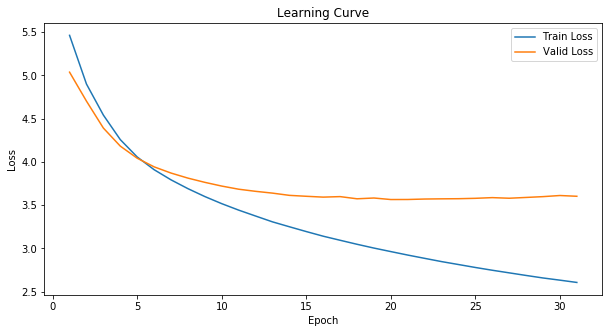

In [ ]:
import seaborn as sns
loss_history = pd.DataFrame({'Epoch': np.arange(1, len(train_loss)),'Train Loss': train_loss, 'Valid Loss': valid_loss})
loss_history.to_csv('Loss_History.csv', index = False, header = True)

fig, ax = plt.subplots(1, 1, figsize = (10,5))                                  # Create a canvas                    

sns.lineplot(data = loss_history, x = 'Epoch', y = 'Train Loss', ax = ax)       # Plot the train loss
sns.lineplot(data = loss_history, x = 'Epoch', y = 'Valid Loss', ax = ax)       # Plot the validation loss 

ax.legend(['Train Loss', 'Valid Loss'])                                         # Mention the legend for complete information
ax.set_ylabel('Loss')                                                           # Label the Y-axis appropriately
ax.set_title('Learning Curve');                                                 # Set the title
plt.savefig('LearningCurve.png');

As we can see from the learning curve, both the train and validation loss are on a decline which is a good trend for the first several Epochs.

However after around 10 epochs we can see that the rate of decrease in train loss is far more than that in the validation loss. If we continue to run it for even more epochs, this divide will further increase and model will overfit to a large extent. That's why we decide to stop and not train for more epochs even if validation loss is gradually ever so on a decline.

___

## BLEU Score

BLEU is short for *Bilingual Evaluation Understudy*. It is an algorithm which crudely compares the quality of machine output and human output in textual problems.

On a high level, it takes n-grams of a human generated caption and corresponding n-grams of a machine genrated caption and looks for common elements. The n-grams are inclusive of unordered ones. The more the common elements between the corresponding n-grams of the two captions, the better the caption quality. 

I said it's a crude comparison because it gives weightage to unordered sets too thereby making a weak case for the sentences where the occurrence of words in a particular order can change the meaning of the sentence. Since our system of caption generation is quite simple and doesn't involve such intricacies, this method is a decent one to gauge our model's performance.

`nltk` has inbuilt methods to compute the BLEU score given a caption's word as compared to the reference words in the corpus (human annotated captions). We will be using `corpus_bleu` method in the `nltk.translate.bleu_score` module to compare our captions.

Let's load images from the test data, create captions for them and also note the reference captions on the go. Eventually let's compare the corpus bleu score for these two.

In [ ]:
# Load the model from memory
model = load_model('/content/drive/My Drive/model_4.h5')

In [ ]:
def index_to_word(integer, tokenizer):
	'''
	Given the index for a word, it returns a word if the same is present in 
	the dictionary on which the model was trained.
	'''
	ix_to_word = {v:k for k,v in tokenizer.word_index.items()}										# Generate a dictionary that maps every index to it's respective word									
	if integer in ix_to_word:
		return ix_to_word[integer]																									# If the index 'integer' exists within the dictionary, then return that
	return None																																		# Else, return None

def generate_desc(model, tokenizer, image_features, max_length):
	'''
	Given a trained model and a tokenizer containing words on which the model was
	trained, it generates caption for the provided image.
	'''
	input_string = 'startseq'																											# Every Caption starts with a <startseq> token. Manually feed it as the first word to the network.
	
	for i in range(max_length):																										# Iterate for the maximum length of the caption in train
		
		seq = tokenizer.texts_to_sequences([input_string])[0]												# Tokenize input sequence with integers
		seq = pad_sequences([seq], maxlen=max_length, padding = 'post')							# Pad input to be of the same length as the biggest caption

		
		pred = model.predict([image_features, seq])																	# Predict the distribution of the successive item
		pred = np.argmax(pred)																											# From the probability distribution above, obtain the most likely word
		word = index_to_word(pred, tokenizer)																				# Look up for the index in the tokenizer disctionary and get the associated word
		
		# stop if we cannot map the word
		if word is None:
			break
		input_string = input_string + ' ' + word
		
		if word == 'endseq':																												# Stop generating more caption words if we predict the end of the sequence
			break
	
	temp = input_string.split(' ')
	temp.remove('startseq')

	while ('endseq') in temp:
		temp.remove('endseq')
	return " ".join(temp)

In [ ]:
corpus_words = []
predicted_caption_words = []
predicted_captions = {}

# Evaluating the model on test dataset
for image, true_captions in tqdm(valid_descriptions.items()):
  pred = generate_desc(model, train_tk, valid_image_features[image], max_len)

  reference_corpus = [caption.split(' ') for caption in true_captions]

  while 'startseq' in reference_corpus:
    reference_corpus.remove('startseq')
  while 'endseq' in reference_corpus:
    reference_corpus.remove('endseq')
  
  corpus_words.append(reference_corpus)
  predicted_caption_words.append(pred.split(' '))
  predicted_captions[image] = pred

In [ ]:
print('BLEU-1: %f' % corpus_bleu(corpus_words, predicted_caption_words, weights=(1., 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(corpus_words, predicted_caption_words, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(corpus_words, predicted_caption_words, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(corpus_words, predicted_caption_words, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.402845
BLEU-2: 0.232844
BLEU-3: 0.163721
BLEU-4: 0.075145


# Bonus

Now that our model is trained and saved, we can use it in order to make predictions. I have done the same in a different notebook. However in this notebook, I have defined a function below which gets the predictions from a random image in the test dataset.

In [ ]:
def get_random_prediction():
  rand_idx = np.random.randint(len(test_image_names))
  img = test_image_names[rand_idx]

  image_features = test_image_features[img]

  input_string = 'startseq'	
  for i in range(max_len):																										  # Iterate for the maximum length of the caption in train
		
    seq = train_tk.texts_to_sequences([input_string])[0]												# Tokenize input sequence with integers
    seq = pad_sequences([seq], maxlen=max_len, padding = 'post')							  # Pad input to be of the same length as the biggest caption


    pred = model.predict([image_features, seq])																	# Predict the distribution of the successive item
    pred = np.argmax(pred)																											# From the probability distribution above, obtain the most likely word
    word = index_to_word(pred, train_tk)																				# Look up for the index in the tokenizer disctionary and get the associated word

    # stop if we cannot map the word
    if word is None:
      break
    input_string = input_string + ' ' + word

    if word == 'endseq':																											  # Stop generating more caption words if we predict the end of the sequence
      break
  
  caption = " ".join([i for i in input_string.split() if i!='startseq' and i!= 'endseq'])

  img_pth = f"/content/drive/My Drive/flicker8k-dataset/Flickr8k_Dataset/Test/{img}"
  im = np.array(Image.open(img_pth))

  fig, ax = plt.subplots(1, 2, figsize = (15,10))
  ax[0].imshow(im)
  ax[0].axis('off')
  ax[0].set_title('Original Image')

  original_caption = random.sample(test_descriptions[img], 1)[0]
  original_caption = [i for i in original_caption.split(' ') if i!='startseq' and i!= 'endseq']
  original_caption = " ".join(original_caption)
  
  textstr = f"Original: {original_caption} \nPredicted: {caption}"

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax[1].set_xlim([0,0.5])
  ax[1].set_ylim([0,0.5])
  ax[1].text(0, 0.45, textstr, transform=ax[1].transAxes, fontsize=20,
        verticalalignment='center', bbox=props)
  ax[1].axis('off')

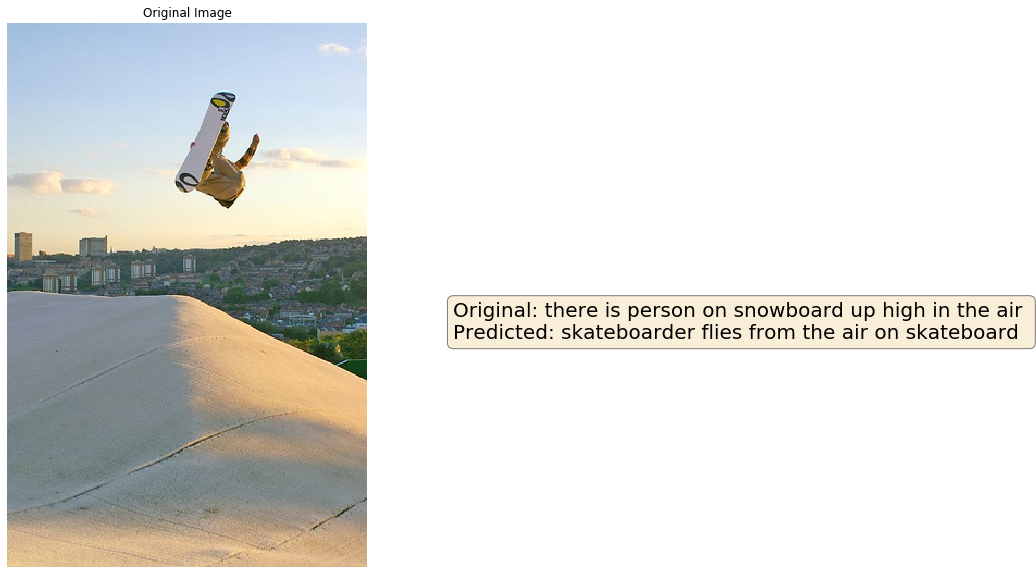

In [ ]:
get_random_prediction()

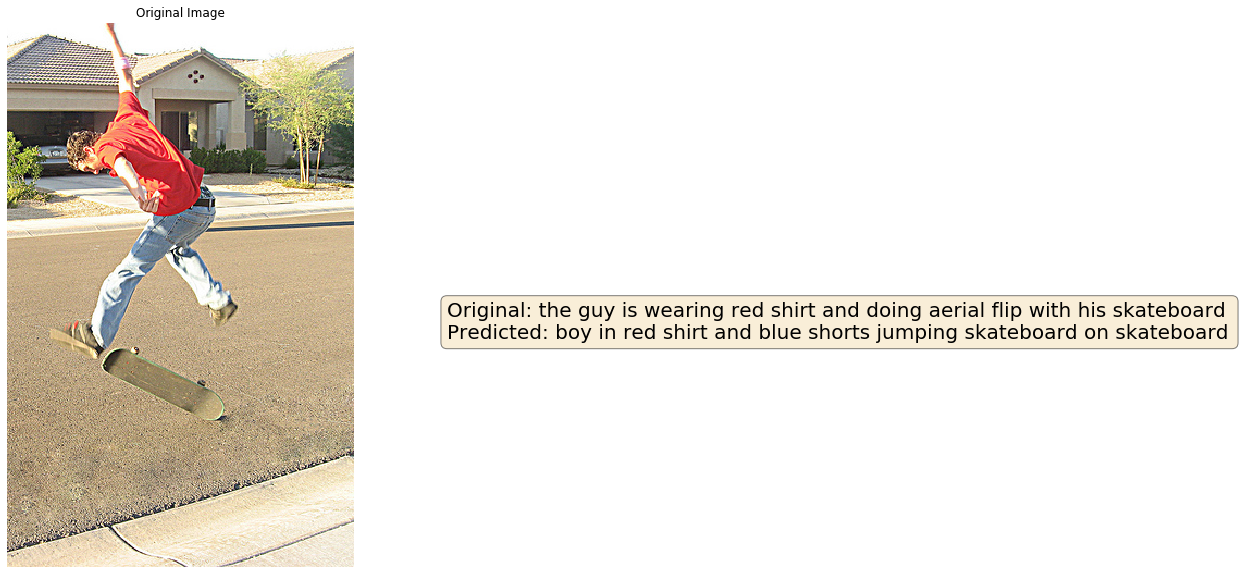

In [ ]:
get_random_prediction()